In [128]:
using Images, ImageFiltering, FileIO, ImageView, ImageMorphology, ColorTypes, ImageDraw, Colors

ArgumentError: ArgumentError: Package ImageFiltering not found in current path, maybe you meant `import/using .ImageFiltering`.
- Otherwise, run `import Pkg; Pkg.add("ImageFiltering")` to install the ImageFiltering package.

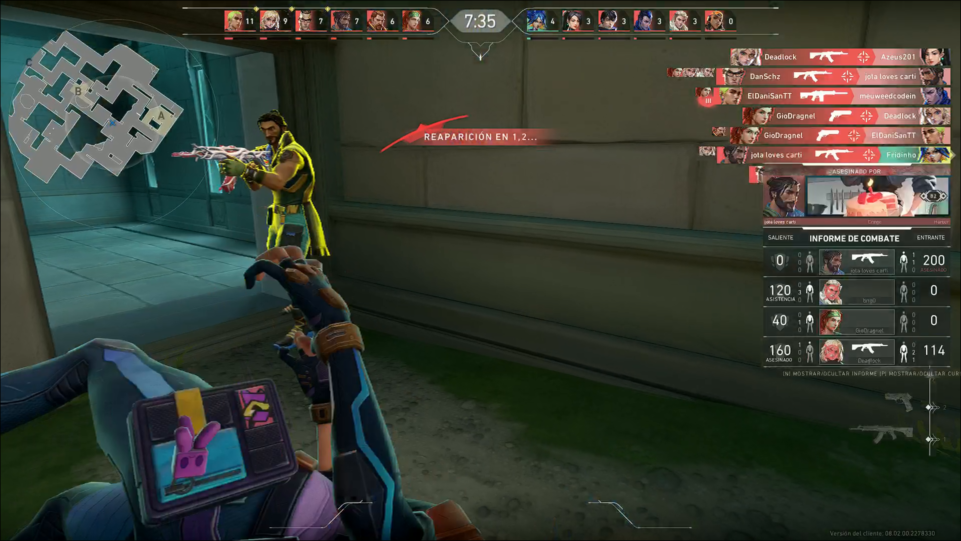

In [129]:
img = load("Frames/edition1/frame23_194.png")

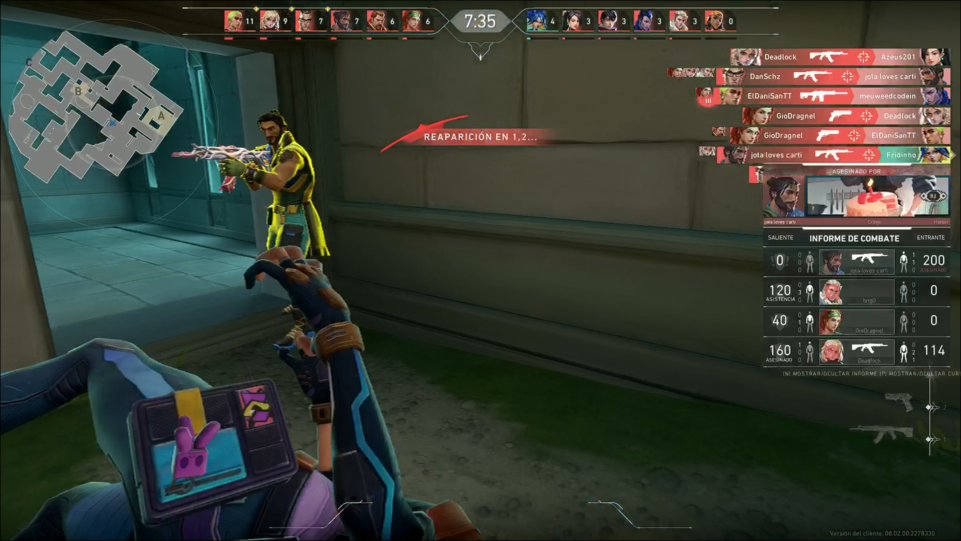

In [130]:
img_hsv = HSV.(img)

In [131]:
# Define the yellow color range in HSV, ensuring the type matches img_hsv pixels
yellow_low = HSV{Float32}(40, 100/255, 155/255)


In [132]:
yellow_high = HSV{Float32}(71, 255/255, 255/255)

In [133]:
mask = map(img_hsv) do pixel
    h, s, v = pixel.h, pixel.s, pixel.v
    h_low, s_low, v_low = yellow_low.h, yellow_low.s, yellow_low.v
    h_high, s_high, v_high = yellow_high.h, yellow_high.s, yellow_high.v

    h_in_range = h_low <= h <= h_high
    s_in_range = s_low <= s <= s_high
    v_in_range = v_low <= v <= v_high

    return h_in_range && s_in_range && v_in_range ? 1 : 0
end

1080×1920 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 ⋮              ⋮              ⋮        ⋱        ⋮              ⋮           
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  

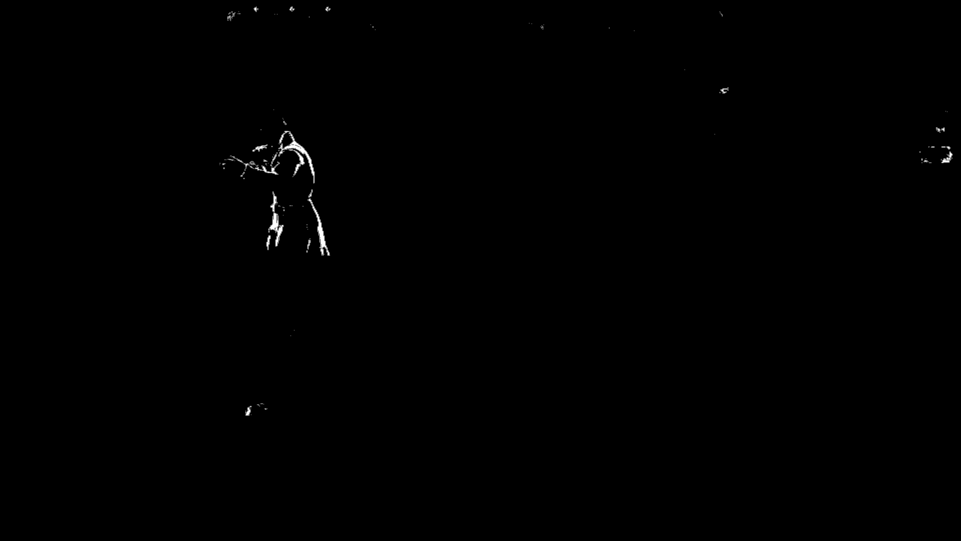

In [134]:
# Convert mask to grayscale image for morphological operations
mask_gray = Gray.(mask)

In [135]:
se = centered(Bool[
    0 0 1 1 1 0 0
    0 1 1 1 1 1 0
    1 1 1 1 1 1 1
    1 1 1 1 1 1 1
    1 1 1 1 1 1 1
    0 1 1 1 1 1 0
    0 0 1 1 1 0 0
])

se2 = centered(Bool[
    0 0 1 0 0  
    0 1 1 1 0  
    1 1 1 1 1  
    0 1 1 1 0 
    0 0 1 0 0 
])

5×5 OffsetArray(::Matrix{Bool}, -2:2, -2:2) with eltype Bool with indices -2:2×-2:2:
 0  0  1  0  0
 0  1  1  1  0
 1  1  1  1  1
 0  1  1  1  0
 0  0  1  0  0

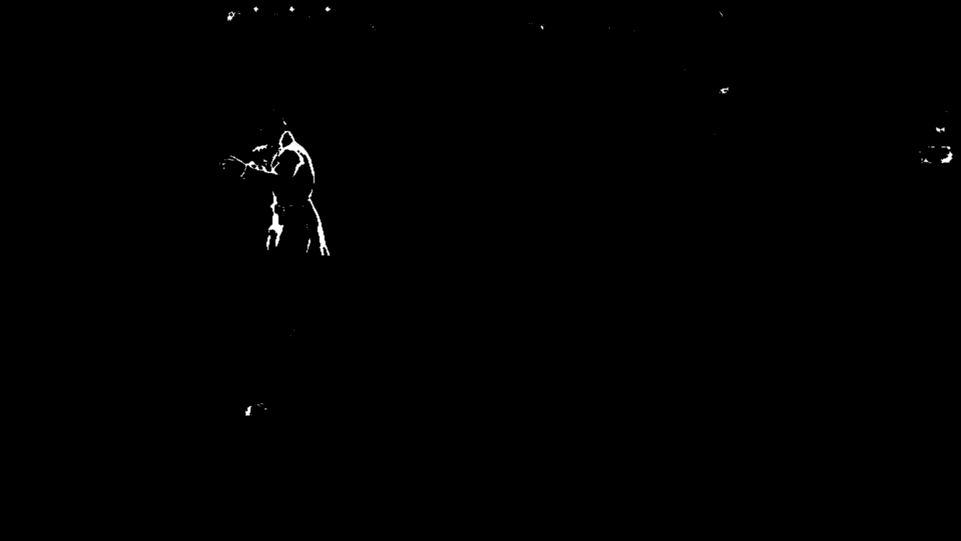

In [136]:
#img_erode = @. Gray(mask_gray < 0.1); # keeps white objects white
img_erosion1 = closing(mask_gray,se2)

In [137]:

function bounding_boxes(mask::Array{T, 2}) where {T}
    # Encontrar los objetos en la máscara binaria
    objects = label_components(mask)
    
    # Inicializar un vector para almacenar los bounding boxes de cada objeto
    bounding_boxes_list = Tuple[]
    
    # Iterar sobre cada objeto y calcular su bounding box
    for obj in 1:maximum(objects)
        # Crear una máscara para el objeto actual
        obj_mask = objects .== obj
        
        # Encontrar los índices de los píxeles no negros en la máscara del objeto
        non_black_pixels = findall(!isequal(zero(T)), obj_mask)
        
        # Calcular coordenadas mínimas y máximas de los píxeles no negros
        min_x = minimum(i[2] for i in non_black_pixels)
        max_x = maximum(i[2] for i in non_black_pixels)
        min_y = minimum(i[1] for i in non_black_pixels)
        max_y = maximum(i[1] for i in non_black_pixels)
        
        # Agregar el bounding box a la lista
        push!(bounding_boxes_list, (min_x, min_y, max_x, max_y))
    end
    
    # Devolver la lista de bounding boxes
    return bounding_boxes_list
end

bounding_boxes (generic function with 1 method)

In [138]:
bbox = bounding_boxes(img_erosion1)


110-element Vector{Tuple}:
 (439, 326, 440, 326)
 (439, 329, 439, 329)
 (445, 327, 450, 329)
 (447, 335, 448, 337)
 (449, 319, 450, 319)
 (452, 319, 452, 319)
 (455, 23, 470, 40)
 (455, 318, 466, 320)
 (457, 25, 461, 29)
 (460, 312, 460, 312)
 ⋮
 (1858, 325, 1862, 325)
 (1862, 293, 1868, 294)
 (1872, 255, 1888, 264)
 (1882, 303, 1904, 325)
 (1883, 293, 1890, 294)
 (1891, 222, 1891, 222)
 (1893, 293, 1900, 298)
 (1893, 308, 1893, 308)
 (1894, 223, 1894, 223)

In [139]:
function merge_close_bounding_boxes(bounding_boxes_list::Vector{T}, threshold::Real) where T<:Tuple
    # Creamos una copia de la lista original de bounding boxes para no modificarla directamente
    merged_boxes = deepcopy(bounding_boxes_list)
    
    # Bandera para indicar si se han realizado fusiones
    merged = true
    
    # Iteramos hasta que no haya más fusiones
    while merged
        merged = false
        
        # Iteramos sobre cada par de bounding boxes
        for i in 1:length(merged_boxes)-1
            for j in i+1:length(merged_boxes)
                box1 = merged_boxes[i]
                box2 = merged_boxes[j]
                
                # Calculamos la distancia entre los centros de las bounding boxes
                center1 = ((box1[1] + box1[3]) / 2, (box1[2] + box1[4]) / 2)
                center2 = ((box2[1] + box2[3]) / 2, (box2[2] + box2[4]) / 2)
                distance = sqrt((center1[1] - center2[1])^2 + (center1[2] - center2[2])^2)
                
                # Si la distancia es menor que el umbral, fusionamos las bounding boxes
                if distance < threshold
                    merged_boxes[i] = (min(box1[1], box2[1]), min(box1[2], box2[2]), max(box1[3], box2[3]), max(box1[4], box2[4]))
                    deleteat!(merged_boxes, j)
                    merged = true
                    break
                end
            end
            
            if merged
                break
            end
        end
    end
    
    return merged_boxes
end


merge_close_bounding_boxes (generic function with 1 method)

In [140]:
function print_merged_bounding_boxes(merged_boxes::Vector{T}) where T<:Tuple
    for (i, bbox) in enumerate(merged_boxes)
        println("Bounding Box $i: ", bbox)
    end
end


print_merged_bounding_boxes (generic function with 1 method)

In [141]:
# Definir umbral de proximidad para la fusión de bounding boxes (ajusta este valor según tus necesidades)
threshold = 100  # Por ejemplo
threshold2 = 100
# Fusionar las bounding boxes cercanas
merged_boxes = merge_close_bounding_boxes(bbox, threshold)


# Imprimir las bounding boxes fusionadas
#print_merged_bounding_boxes(merged_boxes)

12-element Vector{Tuple}:
 (439, 219, 628, 366)
 (455, 13, 618, 41)
 (491, 807, 534, 830)
 (533, 379, 659, 510)
 (581, 660, 588, 671)
 (651, 13, 750, 59)
 (1058, 46, 1087, 58)
 (1218, 55, 1268, 61)
 (1369, 139, 1456, 186)
 (1429, 268, 1429, 268)
 (1439, 23, 1444, 32)
 (1839, 222, 1904, 325)

In [142]:
function draw_bounding_boxes(bounding_boxes_list::Vector{T}, img, color) where T<:Tuple
    # Hacemos una copia profunda de la imagen para no modificar la original
    img2 = deepcopy(img)
    
    # Iteramos sobre todas las bounding boxes en la lista
    for i in 1:length(bounding_boxes_list)
        # Extraemos las coordenadas de la bounding box actual
        x1, y1, x2, y2 = bounding_boxes_list[i]
        
        # Dibujamos los bordes horizontales de la bounding box
        for x in x1:x2
            img2[y1, x] = color
            img2[y2, x] = color
        end
        
        # Dibujamos los bordes verticales de la bounding box
        for y in y1:y2
            img2[y, x1] = color
            img2[y, x2] = color
        end
    end
    
    # Devolvemos la imagen con las bounding boxes dibujadas
    return img2
end


draw_bounding_boxes (generic function with 1 method)

In [143]:
function reduce_bounding_boxes(bounding_boxes_list::Vector{T}, threshold) where T<:Tuple
    # Creamos una copia de la lista de bounding boxes para no modificar la original
    copy_list = copy(bounding_boxes_list)
    
    # Inicializamos un contador para llevar el control de las eliminaciones
    counter = 0
    
    # Iteramos sobre todas las bounding boxes en la lista
    for i in 1:length(bounding_boxes_list)
        # Extraemos las coordenadas de la bounding box actual
        x1, y1, x2, y2 = bounding_boxes_list[i]
        
        # Calculamos el alto y el ancho de la bounding box
        height = y2 - y1
        width = x2 - x1
        
        # Calculamos la proporción entre el ancho y el alto de la bounding box
        x_proportion = width / height
        
        # Verificamos si la bounding box cumple alguna de las condiciones para ser eliminada
        if ((height < threshold && width < threshold) || x_proportion > 5 || x_proportion < 0.2)
            # Si la bounding box no cumple las condiciones, la eliminamos de la lista copiada
            deleteat!(copy_list, i - counter)
            
            # Incrementamos el contador de eliminaciones
            counter += 1
        end
    end
    
    # Devolvemos la lista de bounding boxes después de aplicar las eliminaciones
    return copy_list
end


reduce_bounding_boxes (generic function with 1 method)

In [144]:
reduced_boxes= reduce_bounding_boxes(merged_boxes,15)


7-element Vector{Tuple}:
 (439, 219, 628, 366)
 (491, 807, 534, 830)
 (533, 379, 659, 510)
 (651, 13, 750, 59)
 (1058, 46, 1087, 58)
 (1369, 139, 1456, 186)
 (1839, 222, 1904, 325)

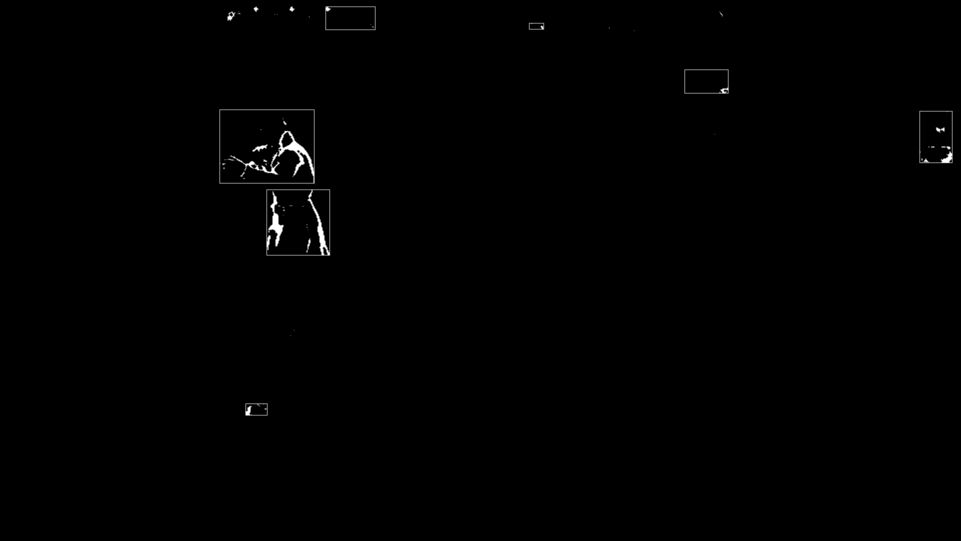

In [145]:
img_bound = draw_bounding_boxes(reduced_boxes, img_erosion1, 1)

In [146]:
function remove_nested_boxes(bounding_boxes::Vector{T}) where T<:Tuple
    # Creamos una lista para almacenar las bounding boxes que no están dentro de otras
    non_nested_boxes = Vector{T}()

    # Iteramos sobre todas las bounding boxes
    for box1 in bounding_boxes
        nested = false

        # Verificamos si la bounding box actual está dentro de otra
        for box2 in bounding_boxes
            if box1 != box2 && is_inside(box1, box2)
                nested = true
                break
            end
        end

        # Si la bounding box no está dentro de ninguna otra, la agregamos a la lista
        if !nested
            push!(non_nested_boxes, box1)
        end
    end

    return non_nested_boxes
end

# Función auxiliar para verificar si una bounding box está completamente contenida dentro de otra
function is_inside(box1, box2)
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2
    return x1 >= x3 && y1 >= y3 && x2 <= x4 && y2 <= y4
end


is_inside (generic function with 1 method)

In [151]:
function join_near_bounding_boxes(bounding_boxes_list::Vector{T}, img, threshold, color) where T<:Tuple
    # Creamos una lista para almacenar las bounding boxes unidas
    joined_boxes = Vector{T}()

    function increase_box(box, threshold)
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        new_x1 = max(1, x1 - threshold)
        new_y1 = max(1, y1 - threshold)
        new_x2 = min(size(img, 2), x2 + threshold)
        new_y2 = min(size(img, 1), y2 + threshold)
        return (new_x1, new_y1, new_x2, new_y2)
    end    

    # Aumentamos ligeramente cada bounding box
    for box in bounding_boxes_list
        increased_box = increase_box(box, threshold)
        push!(joined_boxes, increased_box)
    end

    # Función auxiliar para verificar si dos bounding boxes están superpuestas
    function is_overlapping(box1, box2)
        x1, y1, x2, y2 = box1
        x3, y3, x4, y4 = box2
        return (x1 <= x4 && x3 <= x2 && y1 <= y4 && y3 <= y2)
    end

    # Iteramos sobre todas las bounding boxes en la lista
    for box in joined_boxes
        # Flag para verificar si la bounding box actual se ha fusionado con otra
        joined = false

        # Iteramos sobre las bounding boxes unidas hasta ahora
        for (index, joined_box) in enumerate(joined_boxes)
            # Si la bounding box actual está superpuesta con alguna bounding box unida, fusionamos
            if is_overlapping(box, joined_box)
                # Fusionamos las bounding boxes
                new_box = (min(box[1], joined_box[1]), min(box[2], joined_box[2]), max(box[3], joined_box[3]), max(box[4], joined_box[4]))
                # Actualizamos la lista de bounding boxes unidas
                joined_boxes[index] = new_box
                # Marcamos la flag como verdadera para indicar que esta bounding box se ha fusionado
                joined = true
                break
            end
        end

        # Si la bounding box actual no se ha fusionado, la agregamos a la lista de bounding boxes unidas
        if !joined
            push!(joined_boxes, box)
        end
    end

    joined_boxes = remove_nested_boxes(joined_boxes)

    # Dibujamos las bounding boxes unidas en la imagen utilizando la función existente
    image_with_joined_boxes = draw_bounding_boxes(joined_boxes, img, color)

    return image_with_joined_boxes
end


join_near_bounding_boxes (generic function with 2 methods)

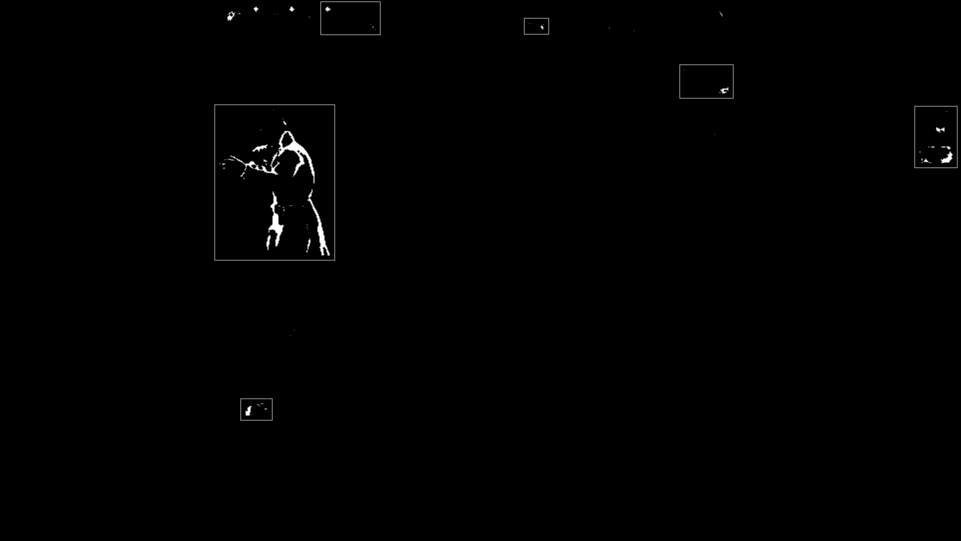

In [154]:
img_unida = join_near_bounding_boxes(reduced_boxes, img_erosion1, 10, 1)